In [1]:
import torch as pt
import torchvision
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
from torch import nn
from torchinfo import summary

## Import necessary libraries

In [2]:
from going_modular import data_setup, engine

## Get data

In [3]:
import os 

from pathlib import Path

#Setup data path
data_path = Path('data/')
image_path = data_path / 'pizza_steak_sushi'

if image_path.is_dir():
    print(f'{image_path} directory exists, skipping re-downloading')
else:
    print(f'Did not find {image_path}, downloading it...')
    image_path.mkdir(parents=True, exist_ok=True)

data\pizza_steak_sushi directory exists, skipping re-downloading


In [4]:
train_dir = image_path / 'train'
test_dir = image_path / 'test'

train_dir, test_dir

(WindowsPath('data/pizza_steak_sushi/train'),
 WindowsPath('data/pizza_steak_sushi/test'))

## Create Datasets and Dataloaders

In [5]:
# let's use data_setup.py and create_dataloaders()
# train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders()

In [6]:
from torchvision import transforms
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229,0.224, 0.225])

manual_transforms = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    normalize
])

In [7]:
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(train_dir=train_dir,
                                                                               test_dir=test_dir,
                                                                               transform=manual_transforms,
                                                                               batch_size=32)
train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x1e38ef97730>,
 ['pizza', 'steak', 'sushi'])

### Creating a transform for `torchvision.models` (auto creation)

In [8]:
# Get a set of pretrained model weights
weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT
weights

EfficientNet_B0_Weights.IMAGENET1K_V1

In [9]:
# Get the transforms used to create our pretrained weights
auto_transforms = weights.transforms()
auto_transforms

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)

In [10]:
# Create DataLoader using automatic transforms
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(train_dir=train_dir,
                                                                               test_dir=test_dir,
                                                                               transform=auto_transforms,
                                                                               batch_size=32)
train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x1e380c28f70>,
 ['pizza', 'steak', 'sushi'])

## Getting a pretrained model

### How to choose PyTorch model?
* Speed
* Size
* Performance

## Setting up a pretrained model

In [11]:
weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT # .DEFAULT - best available weight
model = torchvision.models.efficientnet_b0(weights=weights)
model

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

## EfficientNet feature extractor

In [12]:
model.classifier

Sequential(
  (0): Dropout(p=0.2, inplace=True)
  (1): Linear(in_features=1280, out_features=1000, bias=True)
)

## Different Kinds of Transfer Learning

while performing transfer learning original model layers don't update during training - they stay the same (frozen).
But in case of ImageNet, it has 1000 classes there, while our dataset has only 3, - That's where we should make adjustments.

### Getting a summary of our model with torchinfo.summary()

## Freezing the base model and changing the output layer to suit our needs

In [13]:
model.features

Sequential(
  (0): Conv2dNormActivation(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): SiLU(inplace=True)
  )
  (1): Sequential(
    (0): MBConv(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): SiLU(inplace=True)
        )
        (1): SqueezeExcitation(
          (avgpool): AdaptiveAvgPool2d(output_size=1)
          (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
          (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
          (activation): SiLU(inplace=True)
          (scale_activation): Sigmoid()
        )
        (2): Conv2dNormActivation(
          (0): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), 

In [14]:
summary(model=model,
        input_size=(1,3,224,224), #[batch_size, color_channels, height, width]
        col_names=['input_size', 'output_size', 'num_params', 'trainable'],
        col_width=20,
        row_settings=['var_names'])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [1, 3, 224, 224]     [1, 1000]            --                   True
├─Sequential (features)                                      [1, 3, 224, 224]     [1, 1280, 7, 7]      --                   True
│    └─Conv2dNormActivation (0)                              [1, 3, 224, 224]     [1, 32, 112, 112]    --                   True
│    │    └─Conv2d (0)                                       [1, 3, 224, 224]     [1, 32, 112, 112]    864                  True
│    │    └─BatchNorm2d (1)                                  [1, 32, 112, 112]    [1, 32, 112, 112]    64                   True
│    │    └─SiLU (2)                                         [1, 32, 112, 112]    [1, 32, 112, 112]    --                   --
│    └─Sequential (1)                                        [1, 32, 112, 112]    [1, 16, 112,

In [15]:
# Freeze all the base layers in EffNetB0
for param in model.features.parameters():
    param.requires_grad = False

In [16]:
# Update the classifier head of our model to suit our problem
from torch import nn

pt.manual_seed(42)

model.classifier = nn.Sequential(
    nn.Dropout(p=0.2, inplace=True),
    nn.Linear(in_features=1280,
              out_features=len(class_names))
)

model.classifier

Sequential(
  (0): Dropout(p=0.2, inplace=True)
  (1): Linear(in_features=1280, out_features=3, bias=True)
)

In [17]:
summary(model=model,
        input_size=(1,3,224,224), #[batch_size, color_channels, height, width]
        col_names=['input_size', 'output_size', 'num_params', 'trainable'],
        col_width=20,
        row_settings=['var_names'])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [1, 3, 224, 224]     [1, 3]               --                   Partial
├─Sequential (features)                                      [1, 3, 224, 224]     [1, 1280, 7, 7]      --                   False
│    └─Conv2dNormActivation (0)                              [1, 3, 224, 224]     [1, 32, 112, 112]    --                   False
│    │    └─Conv2d (0)                                       [1, 3, 224, 224]     [1, 32, 112, 112]    (864)                False
│    │    └─BatchNorm2d (1)                                  [1, 32, 112, 112]    [1, 32, 112, 112]    (64)                 False
│    │    └─SiLU (2)                                         [1, 32, 112, 112]    [1, 32, 112, 112]    --                   --
│    └─Sequential (1)                                        [1, 32, 112, 112]    [1, 1

## Train model

In [18]:
# define loss and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = pt.optim.Adam(model.parameters(), lr=0.009)

In [19]:
# Import train function 
from going_modular import engine

# set the manual seeds
pt.manual_seed(42)

# Start the timer
from timeit import default_timer as timer
start_time = timer()

# setup training and save the results
results = engine.train(model=model,
                       train_dataloader=train_dataloader,
                       test_dataloader=test_dataloader,
                       optimizer=optimizer,
                       loss_fn=loss_fn,
                       epochs=10,
                       device='cpu')

# End the timer and print out how long it took 
end_time = timer()
print(f'[INFO] Total training time: {end_time - start_time: .3f} seconds')

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.8726 | train_acc: 0.6367 | test_loss: 0.6526 | test_acc: 0.6600
Epoch: 2 | train_loss: 0.5990 | train_acc: 0.6602 | test_loss: 0.2819 | test_acc: 0.9072
Epoch: 3 | train_loss: 0.3698 | train_acc: 0.8711 | test_loss: 0.2534 | test_acc: 0.9072
Epoch: 4 | train_loss: 0.1990 | train_acc: 0.9570 | test_loss: 0.3583 | test_acc: 0.8258
Epoch: 5 | train_loss: 0.5145 | train_acc: 0.7969 | test_loss: 0.3188 | test_acc: 0.8153
Epoch: 6 | train_loss: 0.5103 | train_acc: 0.7812 | test_loss: 0.4363 | test_acc: 0.8343
Epoch: 7 | train_loss: 0.7701 | train_acc: 0.7344 | test_loss: 0.6563 | test_acc: 0.7737
Epoch: 8 | train_loss: 0.7088 | train_acc: 0.8320 | test_loss: 0.3830 | test_acc: 0.8864
Epoch: 9 | train_loss: 0.2713 | train_acc: 0.8320 | test_loss: 0.4306 | test_acc: 0.8258
Epoch: 10 | train_loss: 0.8423 | train_acc: 0.8047 | test_loss: 0.6469 | test_acc: 0.7841
[INFO] Total training time:  274.374 seconds


In [20]:
from helper_functions import plot_loss_curves

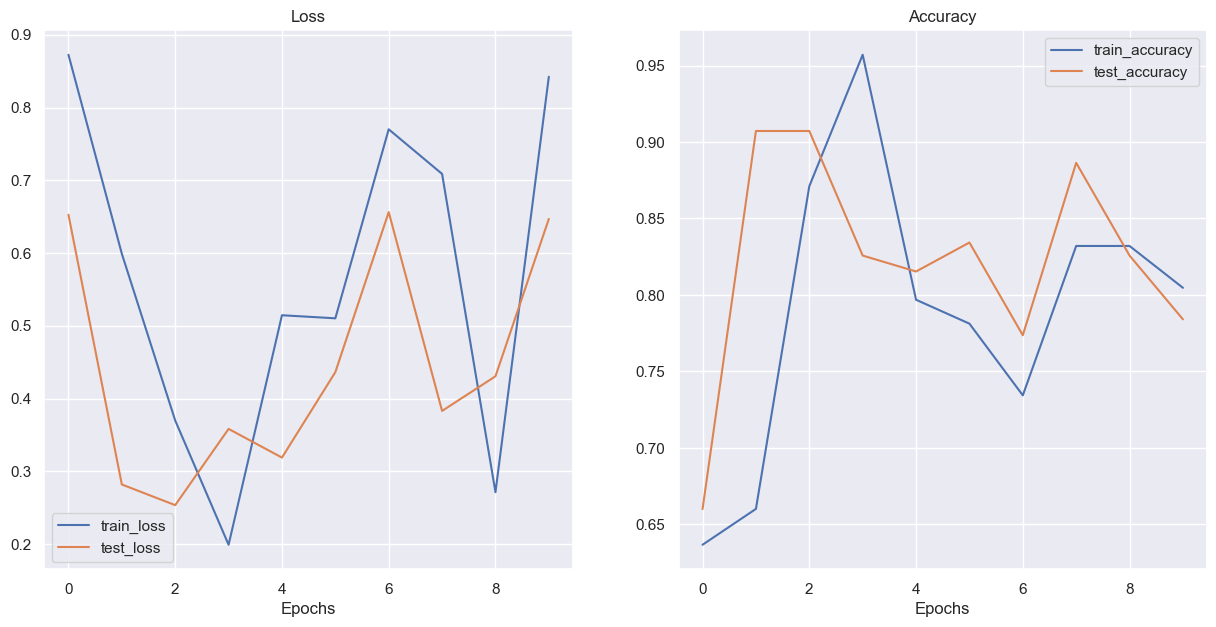

In [21]:
plot_loss_curves(results)

## Make predictions on images from the test set

### Make sure that your data is in the same:
* Same Shape
* Same Datatype
* Same device
* Same transform

In [22]:
# Let's do it automatically
from typing import List, Tuple

from PIL import Image
from PIL import ImageOps

def pred_and_plot_image(model: pt.nn.Module,
                        image_path: str,
                        class_names: List[str],
                        image_size: Tuple[int, int] = (224, 224),
                        transform: torchvision.transforms = None):
    
    img = Image.open(image_path)
    img = ImageOps.exif_transpose(img)

    if transform is not None:
        image_transform = transform
    else:
        image_transform = transforms.Compose([
            transforms.Resize(image_size),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])
        ])

    ### Predict image ###
    model.eval()
    with pt.inference_mode():
        transformed_image = image_transform(img).unsqueeze(dim=0)

        target_image_pred = model(transformed_image)

    target_image_pred_probs = pt.softmax(target_image_pred, dim=1)

    target_image_pred_label = pt.argmax(target_image_pred_probs, dim=1)

    plt.figure()
    plt.axis(False)
    plt.imshow(img)
    plt.title(f'Pred: {class_names[target_image_pred_label]} | Prob: {target_image_pred_probs.max():.3f}')

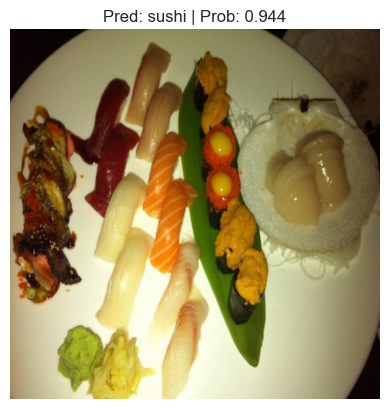

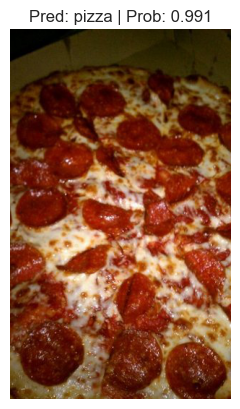

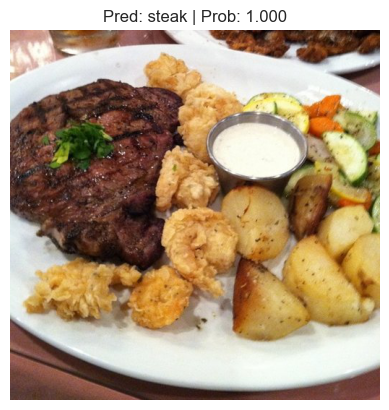

In [23]:
# get a radnom list of image paths form image test set
import random
num_images_to_plot = 3
test_image_path_list = list(Path(test_dir).glob('*/*.jpg'))
test_image_path_sample = random.sample(population=test_image_path_list,
                                       k=num_images_to_plot)

for image_path in test_image_path_sample: 
    pred_and_plot_image(model=model,
                        image_path=image_path,
                        class_names=class_names,
                        image_size=(224,224))

## making predictions on a custom image

In [24]:
custom_image_path = data_path / 'pizza_steak_sushi/Custom_data/Dinner_small.jpg'

if not custom_image_path.is_file():
    print('not here')
else:
    print('here')

here


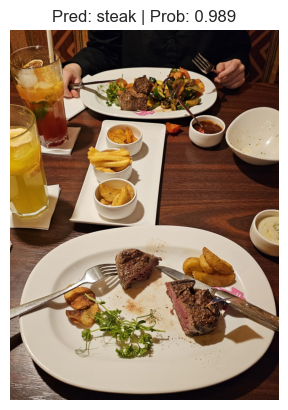

In [25]:
# Predict on custom image
pred_and_plot_image(model=model,
                    image_path=custom_image_path,
                    class_names=class_names)